In [1]:
# import packages

import numpy as np
import matplotlib.pyplot as plt
from keras.optimizers import RMSprop
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, \
    Flatten, Reshape, LeakyReLU, BatchNormalization, Activation
from keras.preprocessing import image
from keras.models import load_model

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
x_train = x_train[y_train==7]
x_test = x_test[y_test==7]

In [4]:
print(x_train.shape)
print(x_test.shape)

(6265, 28, 28)
(1028, 28, 28)


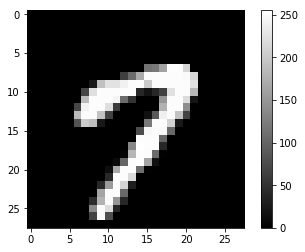

In [5]:
plt.imshow(x_train[0], cmap='gray')
plt.colorbar()

In [6]:
# data reshape : why ? because train_input adjust 
x_train = x_train[:,:,:,np.newaxis]
x_test = x_test[:,:,:,np.newaxis]

In [7]:
# data normalization
x_train = x_train/255
x_test = x_test/255

In [8]:
print(x_train.shape)
print(x_test.shape)

(6265, 28, 28, 1)
(1028, 28, 28, 1)


In [9]:
x_train.shape, x_train.dtype, x_train.max(), x_train.min()

((6265, 28, 28, 1), dtype('float64'), 1.0, 0.0)

In [10]:
input = Input((28,28,1))
x = LeakyReLU(alpha=0.2)(input)

x = Conv2D(32, (5,5), strides=2, padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2D(64, (5,5), strides=2, padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2D(128, (5,5), strides=2, padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2D(256, (5,5), strides=1, padding='same')(x)

x = Flatten()(x)
x = Dense(1, activation='sigmoid')(x)

discriminator = Model(input, x)
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        832       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          51264     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 128)         204928    
__________

In [11]:
discriminator.compile(loss='binary_crossentropy',
                      optimizer=RMSprop(lr=2e-4*0.5, decay=6e-8*0.5), metrics=['acc'])
    # decay 값이 클수록 새롭게(처음으로) 변경되는 가중치를 많이 변화시킨다 (디폴트:0)

In [12]:
# define constructor
input2 = Input((100,)) # 생성벡터는 100차원

x2 = Dense(7*7*128)(input2) # 랜덤 이미지가 입력됨

x2 = Reshape((7,7,128))(x2)

x2 = BatchNormalization()(x2)
x2 = Activation('relu')(x2)

x2 = Conv2DTranspose(128, (5,5), strides=2, padding='same')(x2)
x2 = BatchNormalization()(x2)
x2 = Activation('relu')(x2)

x2 = Conv2DTranspose(64, (5,5), strides=2, padding='same')(x2)
x2 = BatchNormalization()(x2)
x2 = Activation('relu')(x2)

x2 = Conv2DTranspose(32, (5,5), strides=1, padding='same')(x2)
x2 = BatchNormalization()(x2)
x2 = Activation('relu')(x2)

x2 = Conv2DTranspose(1, (5,5), strides=1, padding='same')(x2)
x2 = Activation('sigmoid')(x2)

generator = Model(input2, x2)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
activation_1 (Activation)    (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 128)       409728    
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 128)       512       
__________

In [13]:
# conbine model - gan
discriminator.trainable = False # 모델들을 연결하여 새로운 모델을 만들 때만 적용된다

adversarial = Model(input2, discriminator(generator(input2)))
adversarial.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_2 (Model)              (None, 28, 28, 1)         1301505   
_________________________________________________________________
model_1 (Model)              (None, 1)                 1080577   
Total params: 2,382,082
Trainable params: 1,300,801
Non-trainable params: 1,081,281
_________________________________________________________________


In [14]:
adversarial.compile(loss='binary_crossentropy',
            optimizer=RMSprop(lr=2e-4*0.5, decay=6e-8*0.5), metrics=['acc'])

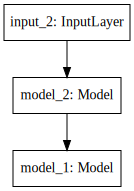

In [15]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(adversarial).create(prog='dot', format='svg'))

In [16]:
batch_size = 64
logs = [] # d_loss,d_acc,a_loss,a_acc

for step in range(1000):
    indices = np.random.randint(0, len(x_train), size=batch_size)
    real_images = x_train[indices]
    
    gen_vectors = np.random.uniform(-1, 1, size=[batch_size,100])
    fake_images = generator.predict(gen_vectors)
    
    X = np.r_[real_images, fake_images] # [batch_size*2,32,32,1]
    y = np.r_[np.ones([batch_size,1]), np.zeros([batch_size,1])] # [batch_size*2,1]
        # fake: 0, real: 1
        
    ###########
    d_loss, d_acc = discriminator.train_on_batch(X, y)
    
    gen_vectors_2 = np.random.uniform(-1, 1, size=[batch_size,100])
    ###########
    a_loss, a_acc = adversarial.train_on_batch(gen_vectors_2, np.ones([batch_size,1]))
            # 타겟값을 모두 1로 놓는다
    
    logs.append([d_loss,d_acc,a_loss,a_acc])
    print('Step: %05d, ' % (step+1), logs[-1])
    
    if (step+1)%10 == 0:
        adversarial.save_weights('gan_mnist.h5')
    
        img = image.array_to_img(fake_images[0]*255., scale=False)
        #img.save('gan_images/fake_'+str(step)+'.png')

C:\Users\kimta\Anaconda3\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Step: 00001,  [0.6946142, 0.28125, 0.8593397, 0.0]
Step: 00002,  [0.6522013, 0.9375, 0.9228313, 0.0]
Step: 00003,  [0.5978441, 0.9921875, 1.0230026, 0.0]
Step: 00004,  [0.54731095, 0.9921875, 1.1294508, 0.0]
Step: 00005,  [0.48887986, 1.0, 1.2580452, 0.0]
Step: 00006,  [0.439037, 1.0, 1.347733, 0.0]
Step: 00007,  [0.37783486, 1.0, 1.5117643, 0.0]
Step: 00008,  [0.33086503, 0.9921875, 1.5929987, 0.0]
Step: 00009,  [0.27006462, 1.0, 1.8537914, 0.0]
Step: 00010,  [0.22408395, 1.0, 1.863689, 0.0]
Step: 00011,  [0.19193268, 1.0, 2.2798405, 0.0]
Step: 00012,  [0.16021478, 1.0, 2.1628456, 0.0]
Step: 00013,  [0.13266982, 1.0, 2.665232, 0.0]
Step: 00014,  [0.10453285, 1.0, 2.5541568, 0.0]
Step: 00015,  [0.08811691, 1.0, 3.11356, 0.0]
Step: 00016,  [0.07549919, 1.0, 2.9458895, 0.0]
Step: 00017,  [0.06479256, 1.0, 3.528487, 0.0]
Step: 00018,  [0.06351231, 1.0, 3.2521975, 0.0]
Step: 00019,  [0.05029831, 1.0, 3.7788458, 0.0]
Step: 00020,  [0.045360915, 1.0, 2.8211877, 0.0]
Step: 00021,  [0.0329098,

In [17]:
generator.save('gan_mnist_generator_1000.h5')

In [18]:
np.save('gan_mnist_log.npy', logs)

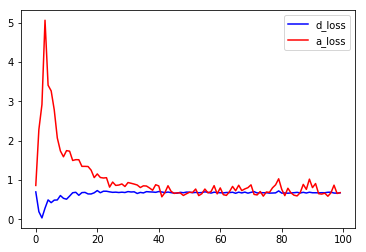

In [19]:
plt.plot([i[0] for i in logs][::10], 'b-', label='d_loss')
plt.plot([i[2] for i in logs][::10], 'r-', label='a_loss')
plt.legend()

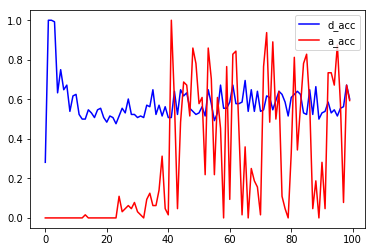

In [20]:
plt.plot([i[1] for i in logs][::10], 'b-', label='d_acc')
plt.plot([i[3] for i in logs][::10], 'r-', label='a_acc')
plt.legend()

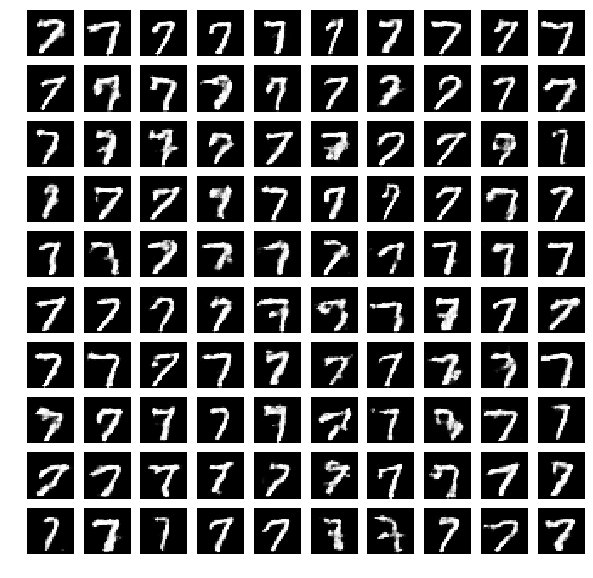

In [21]:
vectors = np.random.uniform(-1, 1, size=[100,100])
images = generator.predict(vectors)

plt.figure(figsize=[10,10])
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.imshow(images[i].reshape(28,28), cmap='gray')
    plt.axis('off')

In [22]:
# Blas GEMM launch failed 
# https://stackoverflow.com/questions/37337728/tensorflow-internalerror-blas-sgemm-launch-failed
#[원인] GPU Memory를 TensorFlow process가 독점하고 있는데, 다른 TensorFlow Process가 GPU Memory에 접근하려고 할때 발생하는 에러.
#[해결책] TensorFlow Session 설정에서 GPU 메모리를 공유하도록 설정해도 되겠지만, 일단 가장 간단한 방법은 jupyter notebook 을 종료하고, 다시 실행시켜서 하나의 kernel만 실행시킨다. jupyter notebook 을 실행시킨 상태에서 pycharm 에서 실행시킨다면 위와 같은 에러가 발생한다.